In [3]:
import numpy as np
import pandas as pd
import torch.nn.functional as F
import pdb
from torch import nn
import math
from torch.optim import lr_scheduler
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
import torch
import itertools
import seaborn as sns
sns.set(style="darkgrid")
from torch.autograd import Variable
from torch.optim import Adam
from torchvision.utils import make_grid
from torchvision.datasets.mnist import MNIST
from tqdm import tqdm
from torchvision import models
import torch.optim as optim
import torchvision
from matplotlib.ticker import MaxNLocator
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from torch.nn import MaxPool2d
!pip install torchsummary
from torchsummary import summary
import chainer.links as L
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.ion()

In [6]:
fashion_mnist = torchvision.datasets.FashionMNIST(root='./data', download=True)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [10]:
fashion_mnist.train_data.size()

torch.Size([60000, 28, 28])

In [14]:
fashion_mnist.train_labels.size()

torch.Size([60000])

In [11]:
fashion_mnist.test_data.size()

torch.Size([60000, 28, 28])

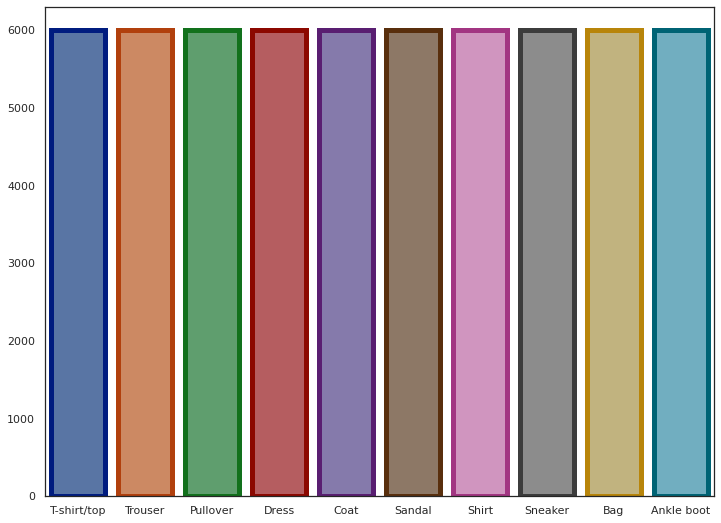

In [23]:
# plot Frequency of classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
fig = plt.figure(figsize=(12,9))
sns.set_style("white")
ax = sns.barplot(x=classes, y=[(fashion_mnist.train_labels == x).sum().item() for x in range(len(classes))],
                linewidth=5, edgecolor=sns.color_palette("dark", 10))

In [17]:
(fashion_mnist.train_labels == 1).sum()

tensor(6000)

# Data Loading in pytorch

In [32]:
class DatasetProcessing(Dataset):
    def __init__(self, data, target, transform=None):
        self.transform = transform
        self.data = data[:, :, : None]
        self.target = target
        
    def __getitem__(self, idx):
        return {'inputs' : self.transform(self.data[idx]), 'labels' : self.target[idx]}
    
    def __len__(self):
        return len(self.target)

In [33]:
# declare transform 
transform = transforms.Compose([transforms.Normalize((0.1307, ), (0.3081, ))]) 
# train and test dataset
train_dataset = DatasetProcessing(fashion_mnist.train_data, fashion_mnist.train_labels, transform)
test_dataset = DatasetProcessing(fashion_mnist.test_data, fashion_mnist.test_labels, transform)

# DataLoader
train_loader = DataLoader(train_dataset, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, shuffle=True, num_workers=8)

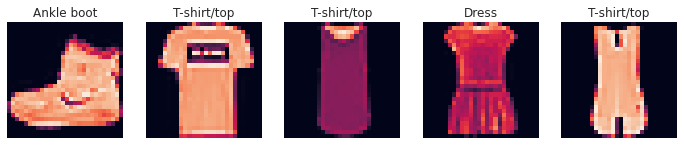

In [38]:
fig = plt.figure(figsize=(12, 6))
for num, x in enumerate(fashion_mnist.train_data[0:5]):
    plt.subplot(1, 5, num+1)
    plt.axis('off')
    plt.imshow(x.numpy())
    plt.title(classes[fashion_mnist.train_labels[num].item()])

# Capsule Networks
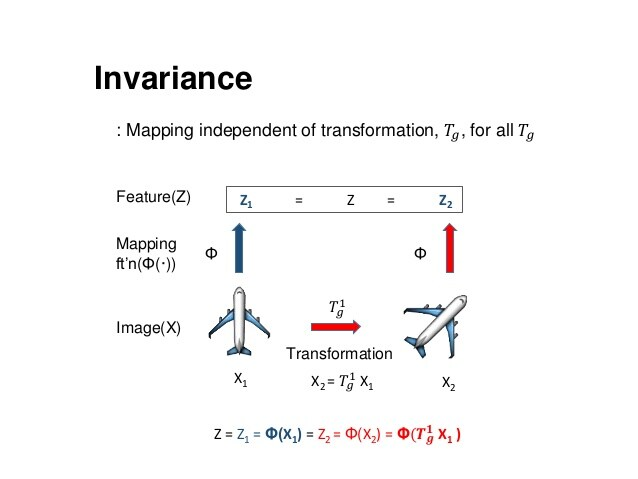
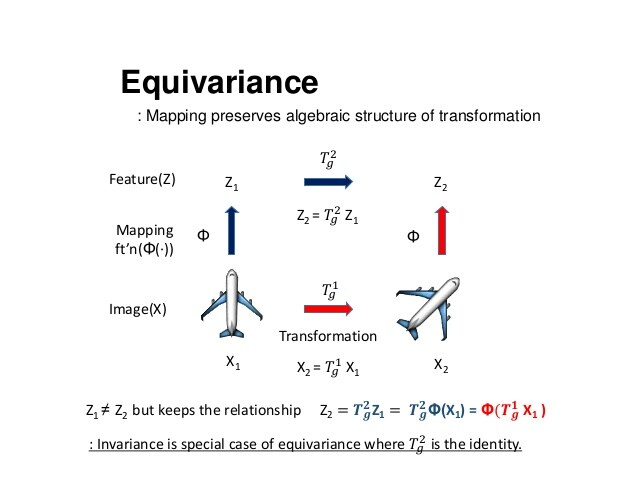

## Archicutre
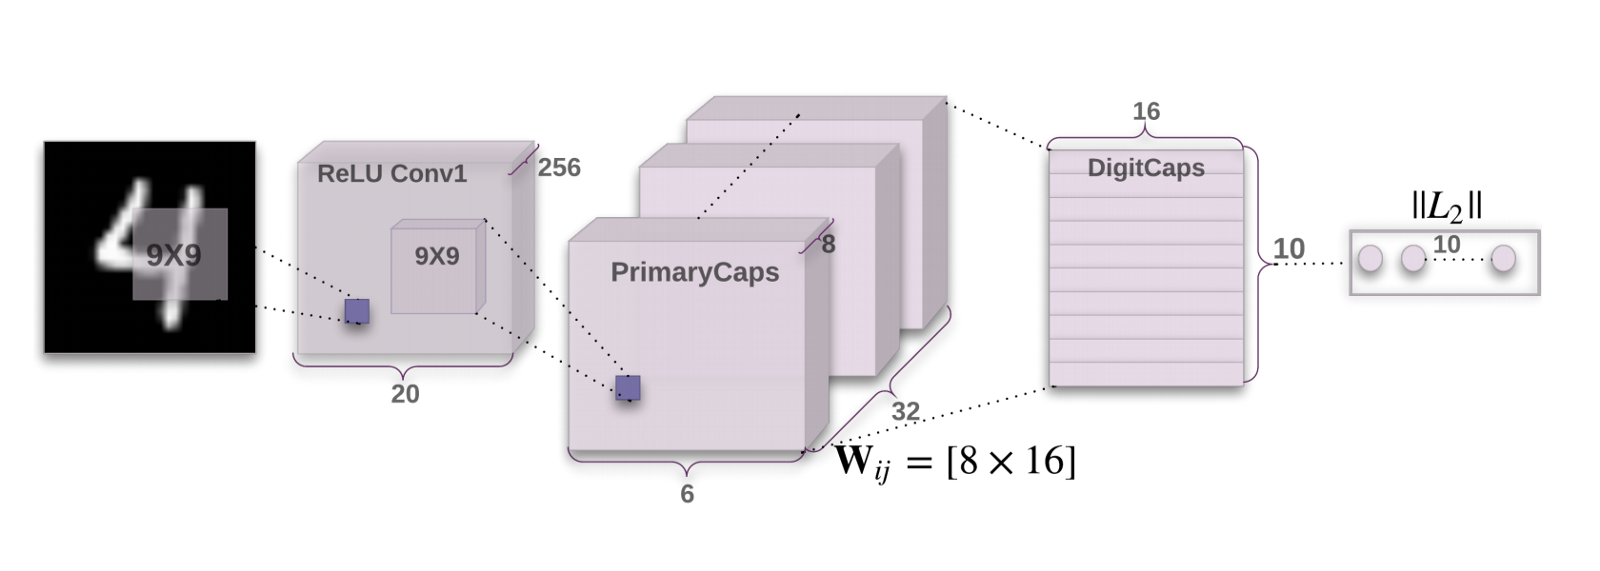
* Level 1: Input layer
* Level 2: CNN layer
* Level 3: Primary Capsules
* level 4: Digit Capsules  
The entire control flow take this form   
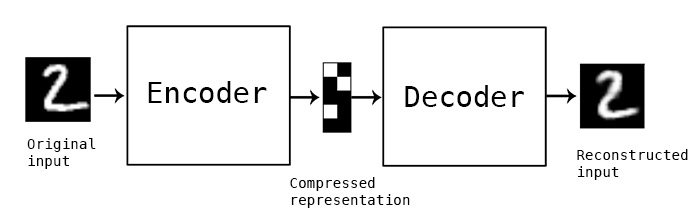  
Reconstructed 는 모델이 overfitting이 되지 않도록 하며 regularizer 역할을 함  
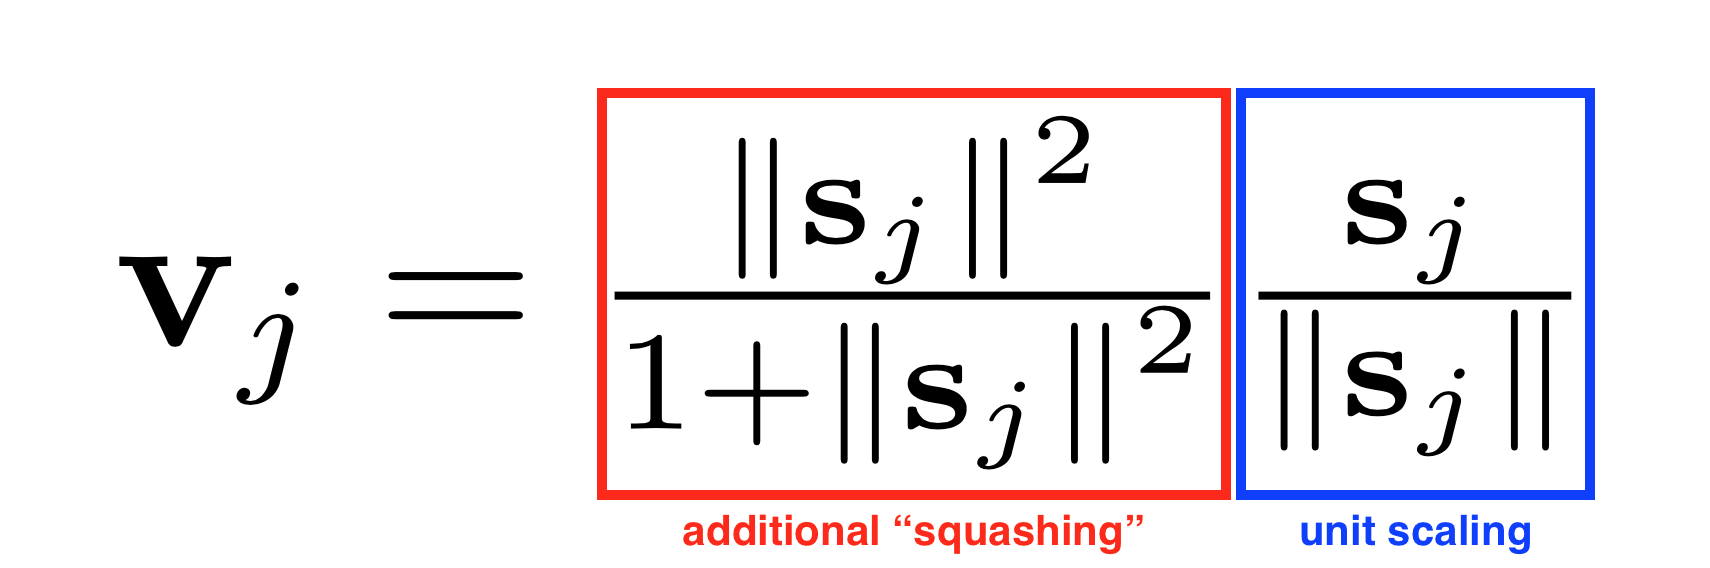!

In [39]:
class CapsuleLevel(nn.Module):
    def __init__(self, in_channels, out_channels, capsule_dimension=8,
                 num_capsules=10, num_capsule_units=6*6*32, routing=False, interations=3):
        super(CapsuleLevel, self).__init__()
        self.routing = routing
        self.iterations = iterations
        self.num_capsules = num_capsules
        self.num_capsule_units = num_capsule_units
        if routing == True:
            self.route_weights = nn.Parameter(torch.randn(num_capsule_units, num_capsules, out_channels, in_channels)) 
        else:
            self.capsules = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=(9,9), stride=(2,2), padding=0) for _ in range(capsule_dimension)])
        
    
    # The squash function
    def squash(self, s, dim=-1):
        norm = torch.sum(s**2, dim=dim, keepdim=True)
        return norm / (1 + norm) * s / (torch.sqrt(norm) + 1e-8)
    
    def forward(self, x):
        if self.routing == True:
            batch_size = x.size(0)
            
            route_weights = torch.stack([self.route_weights] * batch_size, dim=0) # dim: ([1152, 10, 16, 8])
            x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4) # dim: ([128, 1152, 10, 8, 1])
            u_hat = torch.matmul(self.route_weights, x) # dim: ([128, 1152, 10, 16, 1])
            u_hat = u_hat.squeeze(-1) # dim: ([128, 1152, 10, 16])
            temp_u_hat = u_hat.detach()
            
            # b_ij dim: ([128, 1152, 10, 1])
            b_ij = Variable(torch.zeros(batch_size, self.num_capsule_units, self.num_capsules, 1).cuda())
            
            for iteration in range(self.iterations):
                c_ij = F.softmax(b_ij, dim=1) # Equation 1. c_ij dim: ([128, 1152, 10, 1])
                s_ij = (c_ij * temp_u_hat).sum(dim=1) # Equation 2. s_ij dim: ([128, 10, 16])
                temp_u_hat = temp_u_hat.unsqueeze(3) # temp_u_hat dim: ([128, 1152, 10, 16, 1])
                v_j = self.squash(s_ij, dim=2) # Equation 3. v_j dim: ([128, 10, 16])
                v_j_i = torch.stack([v_j] * self.num_capsule_units, dim=1).unsqueeze(-1) # v_j_i dim: ([128, 10, 16, 1])
                v_j_i = torch.matmul(temp_u_hat, v_j_i).squeeze(3)
                temp_u_hat = temp_u_hat.squeeze(3)
                b_ij = b_ij + v_j_i
            
        else:
            v_j = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]
            v_j = torch.cat(v_j, dim=-1)
            v_j = self.squash(v_j)
            
        return v_j

In [40]:
class CapsuleNetwork(nn.Module):
    def __init__(self):
        super(CapsuleNetwork, self).__init__()
        self.batch_size = 32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(9,9), stride=(1,1), padding=0)
        self.primaryCaps = CapsuleLevel(in_channels=256, out_channels=32, capsule_dimension=8)
        self.digitCaps = CapsuleLevel(in_channels=8, out_channels=32, capsule_dimension=8, routing=True)
        self.decoder = nn.Sequential(nn.Linear(16*10, 512), 
                                     nn.ReLU(inplace=True), 
                                     nn.Linear(512, 1024), 
                                     nn.ReLU(inplace=True), 
                                     nn.Linear(1024, 784), 
                                     nn.Sigmoid())
        
    def forward(self, x, y=None):
        x = F.relu(self.conv1(x), inplace=True)
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        classes = (x**2).sum(dim=-1)**0.5
        classes = F.softmax(classes, dim=-1)
        if y is None:
            # get most active capsule
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.eye(10)).cuda().index_select(dim=0, index=Variable(max_length_indices.data))
        reconstructions = self.decoder((x*y[:, :, None]).view(x.size(0), -1))
        
        return classes, reconstructions

# Margin Loss for capsule networks
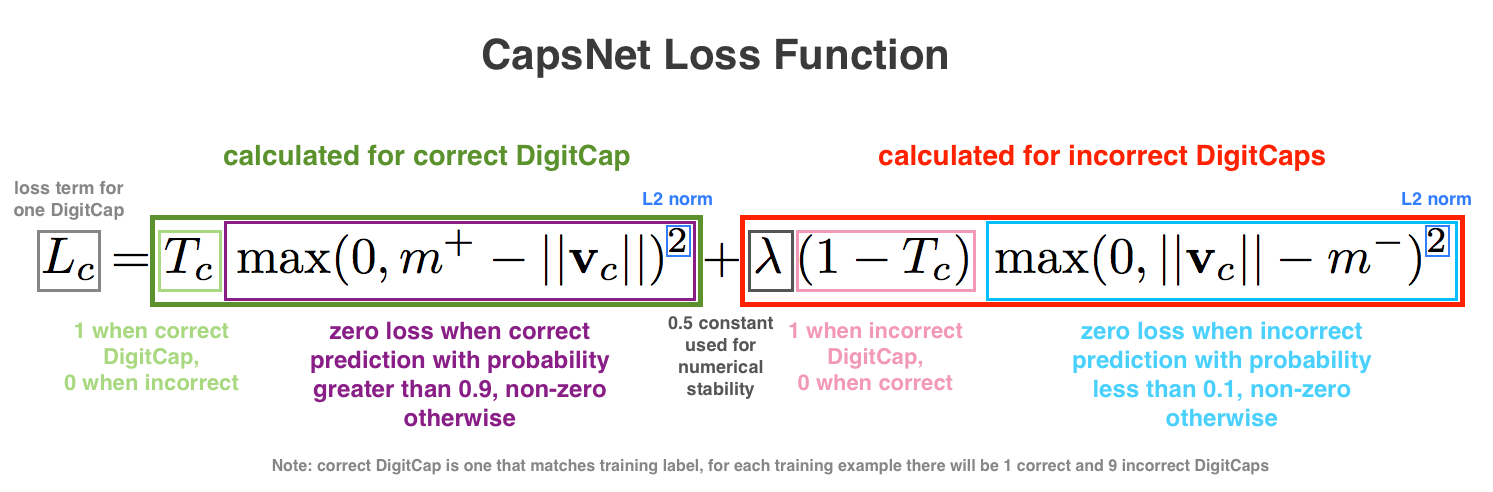

In [41]:
class LossFunction(nn.Module):
    def __init__(self):
        super(LossFunction, self).__init__()
        self.reconstruction_loss = nn.MSELoss(size_average=False)
        
    def forward(self, img, target, classes, reconstructions):
        fn_1 = F.relu(0.9 - classes, inplace=True) ** 2 # Calculated for correct digit cap
        fn_2 = F.relu(classes - 0.1, inplace=True) ** 2 # Calculated for incorrect digit cap
        
        margin_loss = target * fn_1 + 0.5 * (1. - target) * fn_2 # lambda=0.5
        margin_loss = margin_loss.sum()
        
        reconstruction_loss = self.reconstruction_loss(reconstructions, img)
        
        return (margin_loss + 0.0005 * reconstruction_loss) / img.size(0)

In [42]:
train_loss = []
test_loss = []
def train(train_loader, epoch):
    model.train()
    if torch.cuda.is_available():
        model = model.cuda()
    tr_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size = data.size(0)
        labels = target
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        capsule_loss = LossFunction()
        labels = torch.LongTensor(labels)
        labels = torch.eye(10).index_select(dim=0, index=labels)
        labels = Variable(labels).cuda()
        optimizer.zero_grad()
        classes, reconstructions = model(data, labels)
        loss = capsule_loss(data, labels, classes, reconstructions)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        pred = classes.data.max(1, keepdim=True)[1]
        if (batch_idx + 1)% 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))
    train_loss.append(tr_loss / len(train_loader))

In [43]:
def evaluate(data_loader):
    global model
    model.eval()
    loss = 0
    
    for data, target in data_loader:
        labels = target
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        labels = torch.LongTensor(labels)
        labels = torch.eye(10).index_select(dim=0, index=labels)
        labels = Variable(labels).cuda()
        classes, reconstructions = model(data)
        capsule_loss = LossFunction()
        loss += capsule_loss(data, labels, classes, reconstructions).item()
        pred = classes.data.max(1, keepdim=True)[1]
        
    loss /= len(data_loader.dataset)
    test_loss.append(loss)
    print('\nAverage Validation loss: {:.6f}\n'.format(loss))